# HELIO-LEARNING
## Space Weather Prediction using Deep Learning

#### COLLABORATORS
> - #### __Sukumar Hakhoo__
> - #### __Agnit Mukhopadhyay__

#### IDEA
The project will utilize Deep Learning to predict upper-atmospheric (ionospheric) electrical conductance in the aurora/polar regions. The auroral conductance is severely affected by space weather phenomena like solar flares and coronal mass ejections (CMEs).  This project will enable significant improvements in present predictive investigations into the physics and estimation of the auroral conductance.

#### PROBLEM
Global magnetohydrodynamic (MHD) models are used predominantly in space weather prediction. In almost all such global models, the estimation of the ionospheric conductance is conducted using outdated empirical models. This poses a massive challenge, when predicting quantities like the conductance in the aurora/polar region, which are driven mostly by electromagnetic interactions with charged particles, that MHD cannot predict accurately.

We, therefore, intend to use dense neural networks to predict this quantity using inputs from in-situ satellite data and ground-based instruments. This predictive model will be designed to take multiple inputs and return the conductance as an output. Once operational, the model will be installed into the University of Michigan’s Space Weather Modeling Framework (SWMF) to study improvements in space weather predictive skill.

##### __IMPORTS__

In [1]:
import os.path
import numpy as np
import pandas as pd
import seaborn as sns
from os import listdir
import scipy.io as scio
import matplotlib.pyplot as plt
from os.path import isdir, isfile
from sklearn.model_selection import train_test_split

# import numpy.ma as ma
# import datetime as dt
# import pickle

### __DATA ETL__
The data for each day is present in an IDL *.save* file.
This data is obtained directly from the dataset, Assimilative Mapping of Ionospheric Electrodynamics (AMIE).
#### Data Directory structure
    Data
    |-- year
        |-- month
            |-- day.save

#### Checking data characteristics using any one of the data files

In [2]:
# Globals

DATA_DIR = 'Data'
FIELDS_TO_CONSIDER = ['hall conductance (aurora)', 'pedersen conductance (aurora)', 'field-aligned current']
FIELD_NAMES = ['Hall Conductance (Aurora)', 'Pedersen Conductance (Aurora)', 'Field-Aligned Current']
FIELD_SHORT_NAMES = ['h', 'p', 'f']
FILE_LIMIT = 1

In [3]:
def get_random_file():
    years = listdir(DATA_DIR)
    if years:
        random_year = years[0]
        if isdir(DATA_DIR + '/' + random_year):
            months = listdir(DATA_DIR + '/' + random_year)
            if months:
                random_month = months[0]
                if isdir(DATA_DIR + '/' + random_year + '/' + random_month):
                    dates = listdir(DATA_DIR + '/' + random_year + '/' + random_month)
                    if dates:
                        file_name = DATA_DIR + '/' + random_year + '/' + random_month + '/' + dates[0]
                        return file_name

    print('Data unavailable')

In [4]:
f = get_random_file()

In [5]:
if os.path.isfile(f):
    print('AMIE File')
    a = scio.readsav(f)
    for key in a:
        if isinstance(a[key], np.ndarray):
            print('{:<20} = '.format(f'amie[{key}].shape') + str(a[key].shape))
        else:
            print('{:<20} = '.format(f'amie[{key}]') + str(a[key]))
            
    print('\nFields available: \n- ', end = '')
    print('\n- '.join([i.decode("utf-8").strip() for i in a['fields']]))

AMIE File
amie[amie_file]      = b'b20040101n'
amie[data].shape     = (24, 25, 19, 1440)
amie[lats].shape     = (24,)
amie[mlts].shape     = (25,)
amie[time].shape     = (1440,)
amie[fields].shape   = (19,)
amie[imf].shape      = (4, 1440)
amie[ae].shape       = (4, 1440)
amie[dst].shape      = (2, 1440)
amie[hp].shape       = (2, 1440)
amie[cpcp].shape     = (1440,)
amie[version]        = 2.22

Fields available: 
- electric potential
- pedersen conductance (total)
- pedersen conductance (aurora)
- hall conductance (total)
- hall conductance (aurora)
- auroral mean energy (kev)
- auroral energy flux (er/cm2/s)
- electric field (east)
- electric field (north)
- horizontal current (east)
- horizontal current (north)
- horizontal current (magnitude)
- simple joule heating
- auroral mean energy (model)
- auroral energy flux (model)
- pedersen conductance model
- hall conductance model
- potential model
- field-aligned current (!Mm!XA/m!E2!N)


#### Loading all data files

In [3]:
def dataset_metadata_generator():
    location = DATA_DIR
    years = listdir(location)
    for year in years:
        if isdir(location + '/' + year):
            location += '/' + year

            months = listdir(location)
            for month in months:
                if isdir(location + '/' + month):
                    location += '/' + month

                    dates = listdir(location)
                    for date in dates:
                        file_name = location + '/' + date
                        yield year, month, date[7:9], file_name                    

In [4]:
def read_dataset(year, month, date, file_name):
    print(f'Processing file: {year}/{month}/{date}', end=' ')
    if os.path.isfile(file_name):
        a = scio.readsav(file_name)
        
        Fields = [i.decode("utf-8").strip() for i in a['fields']]
        field_indices = [i for field in FIELDS_TO_CONSIDER for i, key in enumerate(Fields) if field in key]
        
        dataset = np.zeros((a['time'].shape[0] * a['lats'].shape[0] * a['mlts'].shape[0], 9))
        
        year, month, date = int(year), int(month), int(date)
        
        row_num = -1
        p = a['time'].shape[0] // 10
        for time_ in range(a['time'].shape[0]):
            if time_ % p == 0:
                print('.', end='')
            for lat in range(a['lats'].shape[0]):
                for mlt in range(a['mlts'].shape[0]):
                    row_num += 1
                    dataset[row_num] = [year,
                                        month,
                                        date,
                                        time_,
                                        a['lats'][lat],
                                        a['mlts'][mlt],
                                        a['data'][lat][mlt][field_indices[0]][time_],
                                        a['data'][lat][mlt][field_indices[1]][time_],
                                        a['data'][lat][mlt][field_indices[2]][time_]]
        print(' [processed]')
        return dataset
    print(f'File not found: {file_name}')

In [5]:
data = None

print('Reading data files.')
for i, detail in enumerate(dataset_metadata_generator()):
    if i + 1 > FILE_LIMIT:
        break
    
    if data is not None:
        data = np.vstack((data, read_dataset(*detail)))
    else:
        data = read_dataset(*detail)
        
print('Shape of loaded data: ' + str(data.shape))

Reading data files.
Processing file: 2004/01/01 .......... [processed]
Shape of loaded data: (864000, 9)


In [6]:
columns = ['Year', 'Month', 'Date', 'Time', 
           'Latitude', 'MLT', 
           'Hall Conductance (Aurora)', 
           'Pedersen Conductance (Aurora)', 
           'Field-aligned current']

data_df = pd.DataFrame(data, columns=columns)
data_df

Year  Month  Date    Time   Latitude   MLT  \
0       2004.0    1.0   1.0     0.0  90.000000   0.0   
1       2004.0    1.0   1.0     0.0  90.000000   1.0   
2       2004.0    1.0   1.0     0.0  90.000000   2.0   
3       2004.0    1.0   1.0     0.0  90.000000   3.0   
4       2004.0    1.0   1.0     0.0  90.000000   4.0   
...        ...    ...   ...     ...        ...   ...   
863995  2004.0    1.0   1.0  1439.0  44.000004  20.0   
863996  2004.0    1.0   1.0  1439.0  44.000004  21.0   
863997  2004.0    1.0   1.0  1439.0  44.000004  22.0   
863998  2004.0    1.0   1.0  1439.0  44.000004  23.0   
863999  2004.0    1.0   1.0  1439.0  44.000004  24.0   

        Hall Conductance (Aurora)  Pedersen Conductance (Aurora)  \
0                        0.603387                       0.686359   
1                        0.603387                       0.686359   
2                        0.603387                       0.686359   
3                        0.603387                       0.686359   
4                        0.603387                       0.686359   
...                           ...                            ...   
863995                   0.263267                       0.282453   
863996                   0.259908                       0.276464   
863997                   0.265354                       0.284564   
863998                   0.269870                       0.289261   
863999                   0.265336                       0.287662   

        Field-aligned current  
0                   -0.000000  
1                   -0.000000  
2                   -0.000000  
3                   -0.000000  
4                   -0.000000  
...                       ...  
863995              -0.000013  
863996               0.000632  
863997               0.001484  
863998               0.002305  
863999               0.002764  

[864000 rows x 9 columns]

In [7]:
data_df = data_df.rename(columns={
    'Hall Conductance (Aurora)': 'Hall_Conductance_(Aurora)', 
    'Pedersen Conductance (Aurora)': 'Pedersen_Conductance_(Aurora)',
    'Field-aligned current': 'Field_aligned_current'
})

In [8]:
data_df[data_df['Field_aligned_current'] > 0].head()

Year  Month  Date  Time  Latitude   MLT  Hall_Conductance_(Aurora)  \
25  2004.0    1.0   1.0   0.0      88.0   0.0                   0.747512   
26  2004.0    1.0   1.0   0.0      88.0   1.0                   0.705329   
27  2004.0    1.0   1.0   0.0      88.0   2.0                   0.890293   
37  2004.0    1.0   1.0   0.0      88.0  12.0                   0.842969   
38  2004.0    1.0   1.0   0.0      88.0  13.0                   0.760856   

    Pedersen_Conductance_(Aurora)  Field_aligned_current  
25                       0.852444               0.001673  
26                       0.796412               0.004226  
27                       0.957106               0.002421  
37                       1.029214               0.001316  
38                       0.940128               0.007792

In [9]:
train, test = train_test_split(data_df, train_size=0.8, shuffle=True)
train.shape, test.shape

((691200, 9), (172800, 9))

In [10]:
features = ['Year', 'Month', 'Date', 'Time', 
            'Latitude', 'MLT', 
            'Field_aligned_current']

MODE = 'hall'
if MODE == 'hall':
    label =  'Hall_Conductance_(Aurora)'
else: 
    label = 'Pedersen_Conductance_(Aurora)'

x_train = train[features].values
y_train = train[label].values
x_test = test[features].values
y_test = test[label].values

### __DATA VISUALIZATION__

#### Visualizing a data file

In [13]:
from matplotlib import pyplot as plt

In [17]:
first_row_detail = data_df.iloc[0].Year, data_df.iloc[0].Month, data_df.iloc[0].Date, data_df.iloc[0].Time

In [12]:
first_date_df = data_df[(data_df['Year'] == first_row_detail[0]) & 
                        (data_df['Month'] == first_row_detail[1]) & 
                        (data_df['Date'] == first_row_detail[2])]
first_date_df

Year  Month  Date    Time   Latitude   MLT  \
0       2004.0    1.0   1.0     0.0  90.000000   0.0   
1       2004.0    1.0   1.0     0.0  90.000000   1.0   
2       2004.0    1.0   1.0     0.0  90.000000   2.0   
3       2004.0    1.0   1.0     0.0  90.000000   3.0   
4       2004.0    1.0   1.0     0.0  90.000000   4.0   
...        ...    ...   ...     ...        ...   ...   
863995  2004.0    1.0   1.0  1439.0  44.000004  20.0   
863996  2004.0    1.0   1.0  1439.0  44.000004  21.0   
863997  2004.0    1.0   1.0  1439.0  44.000004  22.0   
863998  2004.0    1.0   1.0  1439.0  44.000004  23.0   
863999  2004.0    1.0   1.0  1439.0  44.000004  24.0   

        Hall_Conductance_(Aurora)  Pedersen_Conductance_(Aurora)  \
0                        0.603387                       0.686359   
1                        0.603387                       0.686359   
2                        0.603387                       0.686359   
3                        0.603387                       0.686359   
4                        0.603387                       0.686359   
...                           ...                            ...   
863995                   0.263267                       0.282453   
863996                   0.259908                       0.276464   
863997                   0.265354                       0.284564   
863998                   0.269870                       0.289261   
863999                   0.265336                       0.287662   

        Field_aligned_current  
0                   -0.000000  
1                   -0.000000  
2                   -0.000000  
3                   -0.000000  
4                   -0.000000  
...                       ...  
863995              -0.000013  
863996               0.000632  
863997               0.001484  
863998               0.002305  
863999               0.002764  

[864000 rows x 9 columns]

In [177]:
def vizualize(df, x='Latitude', y='MLT', z='Field_aligned_current', figsize=(26, 12), plot='contour'):
    # Pivot the DataFrame
    val_pivot_df = df[[x, y, z]].pivot(columns=x, index=y, values=z)
    x_, y_ = np.meshgrid(val_pivot_df.columns.values, val_pivot_df.index.values)
    
    # Plot
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection='3d')
    if plot == 'contour':
        # draw_contour_single(val_pivot_df, x_, y_, x, y, z, figsize)
        ax.contour3D(x_, y_, val_pivot_df.values, 50)
    elif plot == 'surface':
        # draw_surface_single(val_pivot_df, x_, y_, x, y, z, figsize)
        ax.plot_surface(x_, y_, val_pivot_df.values, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)


# def draw_contour_single(val_pivot_df, x_, y_, x='Latitude', y='MLT', z='Field_aligned_current', figsize=(26, 12)):
#     fig = plt.figure(figsize=figsize)
#     ax = plt.axes(projection='3d')
#     ax.contour3D(x_, y_, val_pivot_df.values, 50)
#     ax.set_xlabel(x)
#     ax.set_ylabel(y)
#     ax.set_zlabel(z)
    
    
# def draw_surface_single(val_pivot_df, x_, y_, x='Latitude', y='MLT', z='Field_aligned_current', figsize=(26, 12)):
#     fig = plt.figure(figsize=figsize)
#     ax = plt.axes(projection='3d')
#     ax.plot_surface(x_, y_, val_pivot_df.values, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
#     ax.set_title('surface');
#     ax.set_xlabel(x)
#     ax.set_ylabel(y)
#     ax.set_zlabel(z)

In [178]:
v = first_date_df[(first_date_df['Time'] == first_row_detail[3]) &
                  (first_date_df['MLT'] < 24)][['Latitude', 'MLT', 'Field_aligned_current']]

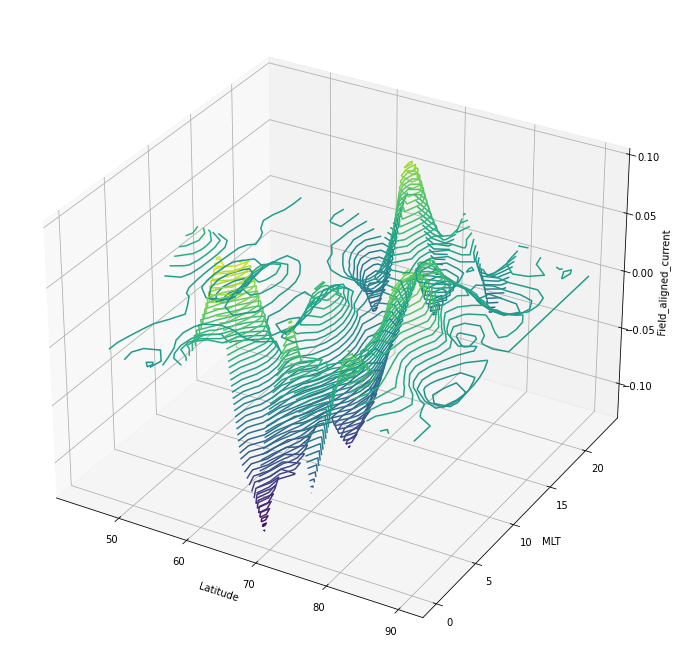

In [179]:
vizualize(v)

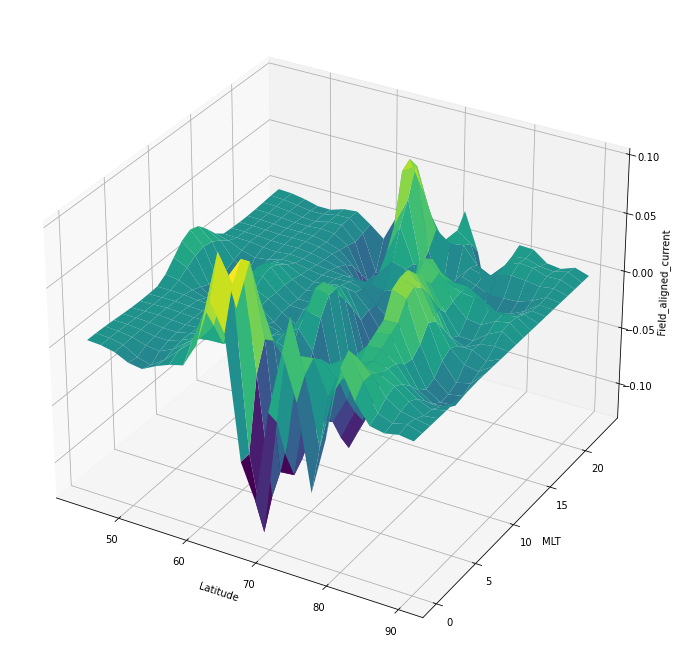

In [180]:
vizualize(v, plot='surface')

In [138]:
v = first_date_df[(first_date_df['Time'] == first_row_detail[3]) &
                  (first_date_df['MLT'] < 24)]

In [157]:
v = first_date_df[first_date_df['MLT'] < 24]

In [158]:
v

Year  Month  Date    Time   Latitude   MLT  \
0       2004.0    1.0   1.0     0.0  90.000000   0.0   
1       2004.0    1.0   1.0     0.0  90.000000   1.0   
2       2004.0    1.0   1.0     0.0  90.000000   2.0   
3       2004.0    1.0   1.0     0.0  90.000000   3.0   
4       2004.0    1.0   1.0     0.0  90.000000   4.0   
...        ...    ...   ...     ...        ...   ...   
863994  2004.0    1.0   1.0  1439.0  44.000004  19.0   
863995  2004.0    1.0   1.0  1439.0  44.000004  20.0   
863996  2004.0    1.0   1.0  1439.0  44.000004  21.0   
863997  2004.0    1.0   1.0  1439.0  44.000004  22.0   
863998  2004.0    1.0   1.0  1439.0  44.000004  23.0   

        Hall_Conductance_(Aurora)  Pedersen_Conductance_(Aurora)  \
0                        0.603387                       0.686359   
1                        0.603387                       0.686359   
2                        0.603387                       0.686359   
3                        0.603387                       0.686359   
4                        0.603387                       0.686359   
...                           ...                            ...   
863994                   0.261264                       0.280001   
863995                   0.263267                       0.282453   
863996                   0.259908                       0.276464   
863997                   0.265354                       0.284564   
863998                   0.269870                       0.289261   

        Field_aligned_current  
0                   -0.000000  
1                   -0.000000  
2                   -0.000000  
3                   -0.000000  
4                   -0.000000  
...                       ...  
863994              -0.000293  
863995              -0.000013  
863996               0.000632  
863997               0.001484  
863998               0.002305  

[829440 rows x 9 columns]

In [ ]:
fig = plt.figure(figsize=(26, 12))
ax = fig.add_subplot(4, 4, 1, projection='3d')

# plot a 3D surface like in the example mplot3d/surface3d_demo
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, linewidth=0, antialiased=False)
ax.set_zlim(-1.01, 1.01)
fig.colorbar(surf, shrink=0.5, aspect=10)

# #===============
# # Second subplot
# #===============
# # set up the axes for the second plot
# ax = fig.add_subplot(1, 2, 2, projection='3d')

# # plot a 3D wireframe like in the example mplot3d/wire3d_demo
# X, Y, Z = get_test_data(0.05)
# ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)

plt.show()

In [175]:
nrows=4
ncols=3
x='Latitude'
y='MLT'
z='Field_aligned_current'

In [ ]:
visualize_multiple(nrows=4, ncols=3, 
                   x='Latitude', y='MLT', z='Field_aligned_current', 
                   time_col_name='Time', 
                   figsize=(32, 42))

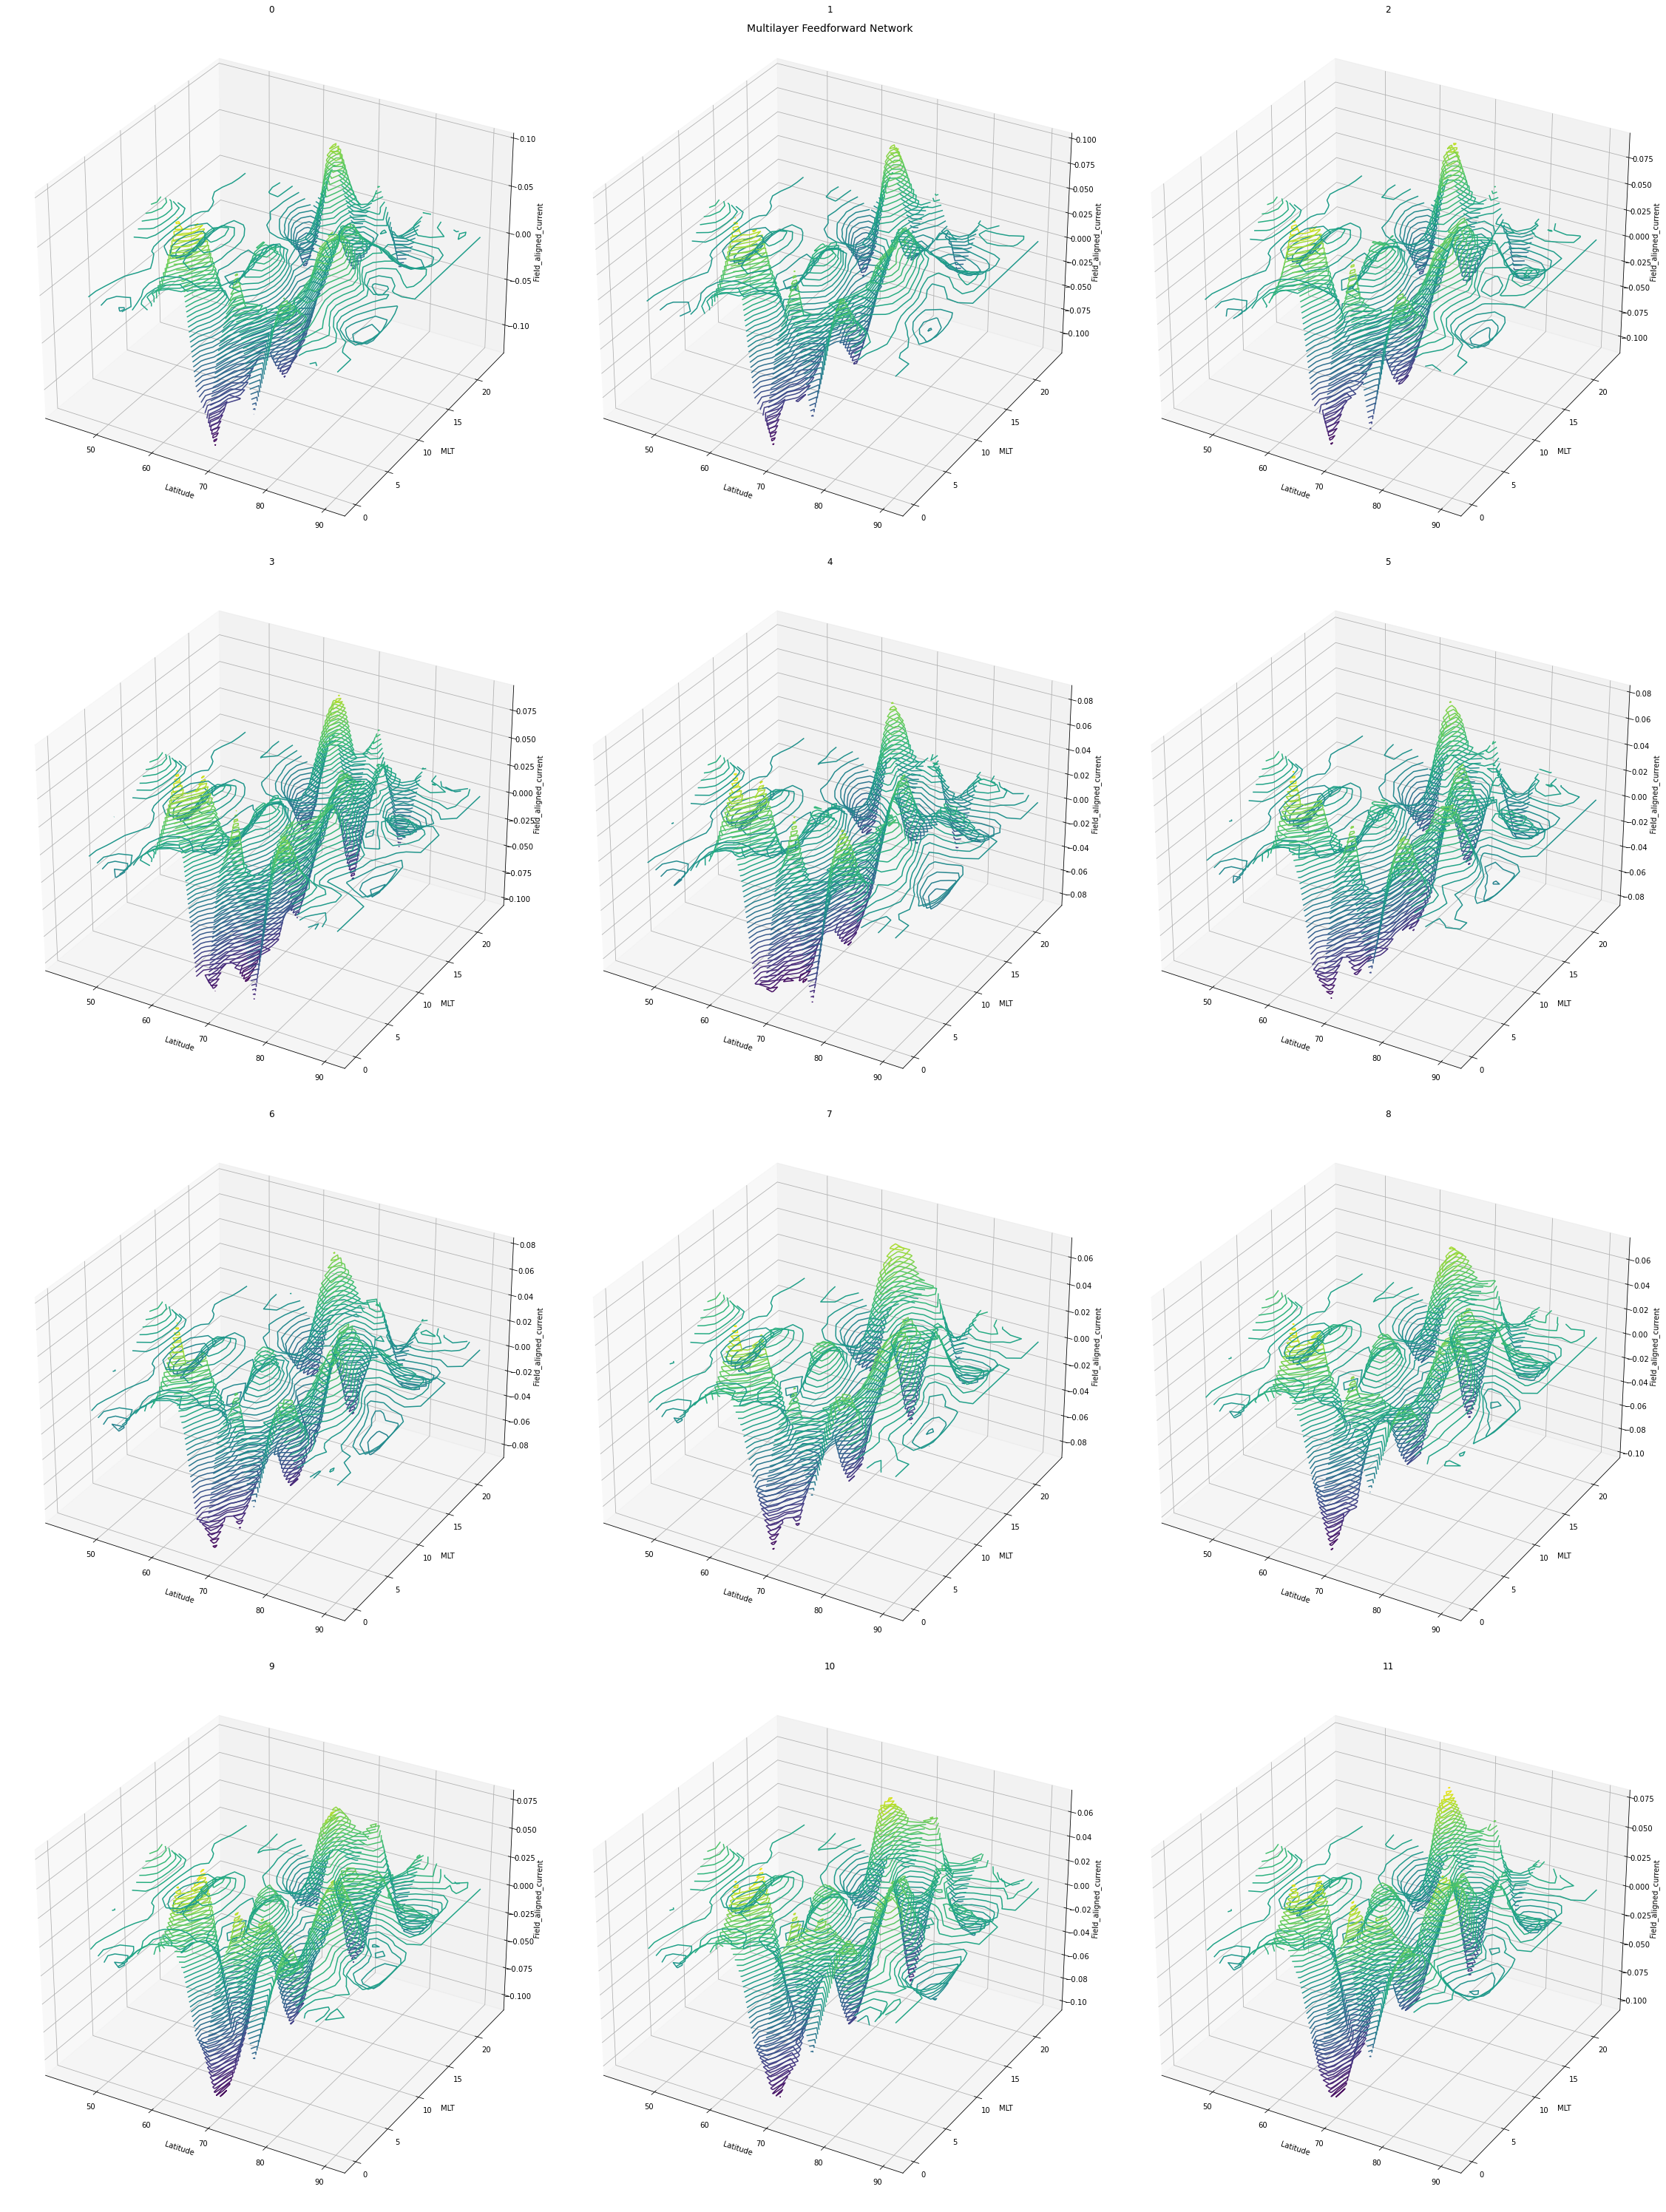

In [176]:
def visualize_multiple(nrows, ncols, x, y, z, time_col_name='Time', figsize=(32, 42)):

    fig = plt.figure(figsize=figsize)
    # fig.suptitle('Multilayer Feedforward Network', fontsize=14)
    t = -1
    for r in range(nrows):
        for c in range(ncols):
            t += 1
            df = v[v[time_col_name] == t][[x, y, z]]
            val_pivot_df = df.pivot(columns=x, index=y, values=z)
            x_, y_ = np.meshgrid(val_pivot_df.columns.values, val_pivot_df.index.values)

            # Plot
            ax = fig.add_subplot(nrows, ncols, t + 1, projection='3d')
            ax.contour3D(x_, y_, val_pivot_df.values, 50)
            ax.set_xlabel(x)
            ax.set_ylabel(y)
            ax.set_zlabel(z)
            ax.set_title(f'Time: {t}')
    fig.tight_layout()
    plt.show()

In [ ]:
ani = animation.FuncAnimation(fig, animate, interval=1000) 

In [15]:
# sns.pairplot(first_date_df[['Latitude', 'MLT', 'Field-aligned current', 'Hall Conductance (Aurora)']], hue='MLT', diag_kind='kde')

In [ ]:
# sns.pairplot(first_date_df[['Time', 'Field_aligned_current', 'Hall_Conductance_(Aurora)']], diag_kind='kde')

In [ ]:
# sns.pairplot(first_date_df[['Latitude', 'MLT', 'Field-aligned current', 'Hall Conductance (Aurora)']], kind='kde')

### __MODEL TRAINING__

Using Dense Neural Networks

In [14]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Flatten, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adagrad, RMSprop, Adadelta, Adam, Nadam
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.layers.experimental import preprocessing

#### Compiling the model

In [18]:
train.describe().transpose()[['mean', 'std']]

mean         std
Year                           2004.000000    0.000000
Month                             1.000000    0.000000
Date                              1.499933    0.500000
Time                            719.483004  415.709480
Latitude                         67.000145   13.843800
MLT                              12.001335    7.213121
Hall Conductance (Aurora)         3.367439    4.359516
Pedersen Conductance (Aurora)     2.735523    2.987895
Field-aligned current             0.000204    0.047613

In [19]:
normalizer = preprocessing.Normalization(input_shape=[7,])
normalizer.adapt(train[features].values)

In [84]:
seed = 156

# layers = [normalizer, Dense(128, kernel_initializer='normal', activation='relu')] + \
#          [Dense(512, kernel_initializer='normal', activation='relu') for _ in range(20)] + \
#          [Dense(1, kernel_initializer='normal', activation='linear')]

layers = [normalizer, Dense(128, kernel_initializer=he_normal(seed=seed), activation='relu')] + \
         [Dense(512, kernel_initializer=he_normal(seed=seed), activation='relu') for _ in range(20)] + \
         [Dense(1, kernel_initializer=he_normal(seed=seed), activation='linear')]

In [85]:
# model = Sequential([
#     normalizer,
#     Dense(100, kernel_initializer=he_normal(seed=seed), bias_initializer='zeros', activation='relu'),
#     Dense(100, kernel_initializer=he_normal(seed=seed), bias_initializer='zeros', activation='relu'),
#     Dense(100, kernel_initializer=he_normal(seed=seed), bias_initializer='zeros', activation='relu'),
#     Dense(100, kernel_initializer=he_normal(seed=seed), bias_initializer='zeros', activation='relu'),
#     Dense(100, kernel_initializer=he_normal(seed=seed), bias_initializer='zeros', activation='relu'),
#     Dense(100, kernel_initializer=he_normal(seed=seed), bias_initializer='zeros', activation='relu'),
#     # Dense(1, kernel_initializer=he_normal(seed=seed), bias_initializer='zeros', activation='softmax')
#     Dense(1, kernel_initializer='normal', activation='linear')
# ])

model = Sequential(layers)

In [86]:
# model.compile(optimizer=tf.keras.optimizers.SGD(nesterov=True),
#                   loss='mean_squared_error',
#                   metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1),
              loss='mean_absolute_error',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

#### Fitting the model on the training data

In [87]:
model.fit(
        x = x_train,
        y = y_train,
        batch_size=512,
        epochs=5,
        verbose=1
    )

Epoch 1/5
2700/2700 [==============================] - 48s 18ms/step - loss: 2.7162 - root_mean_squared_error: 4.8332
Epoch 2/5
2700/2700 [==============================] - 49s 18ms/step - loss: 2.7153 - root_mean_squared_error: 4.8322
Epoch 3/5
2700/2700 [==============================] - 50s 19ms/step - loss: 2.7152 - root_mean_squared_error: 4.8321
Epoch 4/5
2700/2700 [==============================] - 51s 19ms/step - loss: 2.7153 - root_mean_squared_error: 4.8322
Epoch 5/5
2700/2700 [==============================] - 53s 20ms/step - loss: 2.7152 - root_mean_squared_error: 4.8320


#### Evaluation

In [24]:
model.evaluate(x=x_test, y=y_test)

10800/10800 [==============================] - 23s 2ms/step - loss: 2.7372 - root_mean_squared_error: 4.9690


[2.7372496128082275, 4.9690423011779785]

#### Predictor

In [101]:
input_data = {
    'Year': [2004],
    'Month': [1],
    'Date': [2], 
    'Time': [1182],
    'Latitude': [54],
    'MLT': [18],
    'Field_aligned_current': [0.001399]
}

In [102]:
df = pd.DataFrame.from_dict(input_data)
df

Year  Month  Date  Time  Latitude  MLT  Field_aligned_current
0  2004      1     2  1182        54   18               0.001399

In [103]:
predictions = model.predict(df.values)

In [104]:
df[label]  = predictions
df

Year  Month  Date  Time  Latitude  MLT  Field_aligned_current  \
0  2004      1     2  1182        54   18               0.001399   

   Hall Conductance (Aurora)  
0                   1.222658

#### Data Processing

The data in the raw dataset is present as a multi-dimensional array. Each dimension denotes a particular feautre or label. Hence, the data is processed by flattening the raw data into a DataFrame.

In [5]:
import sqlite3

In [6]:
raw_data = None

print('Reading data files.')
for i, detail in enumerate(dataset_metadata_generator()):
    if raw_data is not None:
        raw_data = np.vstack((raw_data, read_dataset(*detail)))
    else:
        raw_data = read_dataset(*detail)
        
print('Shape of loaded data: ' + str(raw_data.shape))

Reading data files.
Processing file: 2004/01/01 .......... [processed]
Processing file: 2004/01/02 .......... [processed]
Processing file: 2004/01/03 .......... [processed]
Processing file: 2004/01/04 .......... [processed]
Processing file: 2004/01/05 .......... [processed]
Processing file: 2004/01/06 .......... [processed]
Processing file: 2004/01/07 .......... [processed]
Processing file: 2004/01/08 .......... [processed]
Processing file: 2004/01/09 .......... [processed]
Processing file: 2004/01/10 .......... [processed]
Processing file: 2004/01/11 .......... [processed]
Processing file: 2004/01/12 .......... [processed]
Processing file: 2004/01/13 .......... [processed]
Processing file: 2004/01/14 .......... [processed]
Processing file: 2004/01/15 .......... [processed]
Processing file: 2004/01/16 .......... [processed]
Processing file: 2004/01/17 .......... [processed]
Processing file: 2004/01/18 .......... [processed]
Processing file: 2004/01/19 .......... [processed]
Processing 

In [7]:
columns = ['Year', 'Month', 'Date', 'Time', 
           'Latitude', 'MLT', 
           'Hall Conductance (Aurora)', 
           'Pedersen Conductance (Aurora)', 
           'Field-aligned current']

processed_data_df = pd.DataFrame(raw_data, columns=columns)
processed_data_df = processed_data_df.rename(columns={
    'Hall Conductance (Aurora)': 'Hall_Conductance_(Aurora)', 
    'Pedersen Conductance (Aurora)': 'Pedersen_Conductance_(Aurora)',
    'Field-aligned current': 'Field_aligned_current'
})

processed_data_df

Year  Month  Date    Time   Latitude   MLT  \
0         2004.0    1.0   1.0     0.0  90.000000   0.0   
1         2004.0    1.0   1.0     0.0  90.000000   1.0   
2         2004.0    1.0   1.0     0.0  90.000000   2.0   
3         2004.0    1.0   1.0     0.0  90.000000   3.0   
4         2004.0    1.0   1.0     0.0  90.000000   4.0   
...          ...    ...   ...     ...        ...   ...   
26783995  2004.0    1.0  31.0  1439.0  44.000004  20.0   
26783996  2004.0    1.0  31.0  1439.0  44.000004  21.0   
26783997  2004.0    1.0  31.0  1439.0  44.000004  22.0   
26783998  2004.0    1.0  31.0  1439.0  44.000004  23.0   
26783999  2004.0    1.0  31.0  1439.0  44.000004  24.0   

          Hall_Conductance_(Aurora)  Pedersen_Conductance_(Aurora)  \
0                          0.603387                       0.686359   
1                          0.603387                       0.686359   
2                          0.603387                       0.686359   
3                          0.603387                       0.686359   
4                          0.603387                       0.686359   
...                             ...                            ...   
26783995                   0.233468                       0.261761   
26783996                   0.231941                       0.259709   
26783997                   0.248517                       0.274084   
26783998                   0.238539                       0.258881   
26783999                   0.230658                       0.252223   

          Field_aligned_current  
0                     -0.000000  
1                     -0.000000  
2                     -0.000000  
3                     -0.000000  
4                     -0.000000  
...                         ...  
26783995              -0.001243  
26783996              -0.000574  
26783997               0.000330  
26783998               0.001254  
26783999               0.001957  

[26784000 rows x 9 columns]

In [94]:
connection = sqlite3.connect("database.db")

In [98]:
processed_data_df.to_sql('processed_data', connection, if_exists='replace')